# Generate Training Data
## Preparation

In [1]:
from scapy.all import *
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
# Formatters for displaying pandas data tables with columns of (lists of) scapy packets

def packet_list_fmt(lst):
    return f"{len(lst)} packets"

def packet_fmt(pkt):
    return pkt[DNS].summary()

In [4]:
ALGO_NAME = {
    0: 'unsigned',
    0: 0,
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}

In [447]:
# retrieve information encoded in DNS qnames

def split_qname(row):
    qname = row['qname']
    parts = qname.decode('ascii').split(".")
    try:
        if ".".join(parts[-3:]) == "dnstb.net.":
            if '-' not in parts[-4]:
                # this qname has a label directly under dnstb.net, store it
                # then remove to be compatible with qnames without label
                qlabel = parts[-4]
                del parts[-4]
            else:
                qlabel = ''
            
            resolver = parts[-5]
            resolver_parts = parts[-5].split("-")            
            if resolver.startswith('lab'):
                resolver = '-'.join(resolver_parts[1:-1])
            elif resolver.startswith('opn-named'):
                resolver = '-'.join(resolver_parts[2:-1])
            elif resolver.startswith('opn-anon'):
                resolver = '-'.join(resolver_parts[2:-1])
                
            if parts[-4] == 'unsigned':
                return {
                    'zone_algorithm': 0,
                    'zone_keysize': 0,
                    'zone_nsec': 0,
                    'zone_status': parts[-4],
                    'resolver': resolver,
                    'qlabel': qlabel,                    
                }
            else:
                zone_parts = parts[-4].split("-")
                return {
                    'zone_algorithm': zone_parts[0],
                    'zone_keysize': zone_parts[1],
                    'zone_nsec': zone_parts[2],
                    'zone_status': zone_parts[3],
                    'resolver': resolver,
                    'qlabel': qlabel,
                }
    except IndexError:
        logging.warning(f"could not split qname {qname} into meaningful information")
        return {
            'zone_algorithm': None,
            'zone_keysize': None,
            'zone_nsec': None,
            'zone_status': None,
            'resolver': None,
            'qlabel': None,
        }
    logging.warning(f"Could not split qname: {qname}")
    return {
        'zone_algorithm': None,
        'zone_keysize': None,
        'zone_nsec': None,
        'zone_status': None,
        'resolver': None,
        'qlabel': None,
    }

## Load Data

In [6]:
# load the traffic logs

c_logs = filter(lambda s: s, """
tcpdump_lab_ws2019_0xb_ens160_20210624190851.pcap
tcpdump_lab_ws2012r2_0x9_ens160_20210624190851.pcap
tcpdump_lab_powerdns460_0xe_ens160_20210624190851.pcap
tcpdump_lab_kresd532_0xd_ens160_20210624190851.pcap
tcpdump_lab_unbound167_0xf_ens160_20210624190851.pcap
tcpdump_lab_bind9113_0xc_ens160_20210624190851.pcap
tcpdump_lab_ws2016_0xa_ens160_20210624190851.pcap
tcpdump_lab_ws2012_0x8_ens160_20210624190851.pcap

tcpdump_opn-named_cloudflare_0x59_ens160_20210624190031.pcap
tcpdump_opn-named_yandex-dns-safe_0x68_ens160_20210624190031.pcap
tcpdump_opn-named_cisco-umbrella_0x58_ens160_20210624190031.pcap
tcpdump_opn-named_Comodo-secure-dns_0x5a_ens160_20210624190031.pcap
tcpdump_opn-named_cznic-odvr_0x5b_ens160_20210624190031.pcap
tcpdump_opn-named_google_0x5d_ens160_20210624190031.pcap
tcpdump_opn-named_norton-connectsafe_0x61_ens160_20210624190031.pcap
tcpdump_opn-named_verisgn-public-dns_0x66_ens160_20210624190031.pcap
tcpdump_opn-named_neustar-free-recursive_0x60_ens160_20210624190031.pcap
tcpdump_opn-named_quad9_0x64_ens160_20210624190031.pcap
tcpdump_opn-named_oracle-dyn_0x63_ens160_20210624190031.pcap
tcpdump_opn-named_opennic_0x62_ens160_20210624190031.pcap
tcpdump_opn-named_hurricane-electric_0x5e_ens160_20210624190031.pcap
tcpdump_opn-named_freenom-world_0x5c_ens160_20210624190031.pcap

tcpdump_opn-anon_8-20-247-66_0x7e_ens160_20210624192146.pcap
tcpdump_opn-anon_185-90-150-135_0x38_ens160_20210624192146.pcap
tcpdump_opn-anon_172-64-47-12_0x87_ens160_20210624192146.pcap
tcpdump_opn-anon_78-29-8-232_0x89_ens160_20210624192146.pcap
tcpdump_opn-anon_62-92-33-250_0x36_ens160_20210624192146.pcap
tcpdump_opn-anon_154-160-67-146_0x2b_ens160_20210624192146.pcap
tcpdump_opn-anon_89-111-43-37_0x85_ens160_20210624192146.pcap
tcpdump_opn-anon_185-228-170-154_0x99_ens160_20210624192146.pcap
tcpdump_opn-anon_178-238-79-167_0x80_ens160_20210624192146.pcap
tcpdump_opn-anon_85-93-125-3_0x9d_ens160_20210624192146.pcap
tcpdump_opn-anon_5-181-17-25_0x84_ens160_20210624192146.pcap
tcpdump_opn-anon_185-228-139-22_0xa8_ens160_20210624192146.pcap
tcpdump_opn-anon_41-220-0-70_0x3c_ens160_20210624192146.pcap
tcpdump_opn-anon_156-0-91-185_0x5b_ens160_20210624192146.pcap
tcpdump_opn-anon_45-174-201-96_0x63_ens160_20210624192146.pcap
tcpdump_opn-anon_37-35-65-33_0xb6_ens160_20210624192146.pcap
tcpdump_opn-anon_103-50-96-104_0x50_ens160_20210624192146.pcap
tcpdump_opn-anon_80-232-36-70_0xac_ens160_20210624192146.pcap
tcpdump_opn-anon_187-19-167-68_0x67_ens160_20210624192146.pcap
tcpdump_opn-anon_210-56-23-67_0x66_ens160_20210624192146.pcap
tcpdump_opn-anon_46-214-78-47_0xc7_ens160_20210624192146.pcap
tcpdump_opn-anon_216-152-165-30_0x57_ens160_20210624192146.pcap
tcpdump_opn-anon_45-5-50-166_0x52_ens160_20210624192146.pcap
tcpdump_opn-anon_72-176-194-192_0x81_ens160_20210624192146.pcap
tcpdump_opn-anon_162-191-51-99_0x34_ens160_20210624192146.pcap
tcpdump_opn-anon_46-152-121-87_0xc3_ens160_20210624192146.pcap
tcpdump_opn-anon_12-238-52-97_0x55_ens160_20210624192146.pcap
tcpdump_opn-anon_196-205-21-252_0x95_ens160_20210624192146.pcap
tcpdump_opn-anon_190-144-50-114_0xa3_ens160_20210624192146.pcap
tcpdump_opn-anon_85-26-247-10_0xd6_ens160_20210624192146.pcap
tcpdump_opn-anon_178-248-151-131_0x4b_ens160_20210624192146.pcap
tcpdump_opn-anon_12-26-126-64_0x2a_ens160_20210624192146.pcap
tcpdump_opn-anon_81-198-65-77_0xe6_ens160_20210624192146.pcap
tcpdump_opn-anon_91-204-85-96_0xef_ens160_20210624192146.pcap
tcpdump_opn-anon_87-140-15-220_0xa5_ens160_20210624192146.pcap
tcpdump_opn-anon_187-120-96-129_0x88_ens160_20210624192146.pcap
tcpdump_opn-anon_189-50-159-14_0x30_ens160_20210624192146.pcap
tcpdump_opn-anon_113-31-148-18_0xe1_ens160_20210624192146.pcap
tcpdump_opn-anon_185-116-163-225_0xfd_ens160_20210624192146.pcap
tcpdump_opn-anon_87-120-5-11_0x6_ens160_20210624192146.pcap
tcpdump_opn-anon_209-141-152-236_0xeb_ens160_20210624192146.pcap
tcpdump_opn-anon_103-35-142-194_0xd0_ens160_20210624192146.pcap
tcpdump_opn-anon_137-74-235-136_0x2_ens160_20210624192146.pcap
tcpdump_opn-anon_190-95-238-242_0xbb_ens160_20210624192146.pcap
tcpdump_opn-anon_24-119-153-182_0xe7_ens160_20210624192146.pcap
tcpdump_opn-anon_162-159-56-115_0x11_ens160_20210624192146.pcap
tcpdump_opn-anon_82-102-10-62_0xf_ens160_20210624192146.pcap
tcpdump_opn-anon_2-180-40-13_0xdf_ens160_20210624192146.pcap
tcpdump_opn-anon_84-232-38-13_0x9_ens160_20210624192146.pcap
tcpdump_opn-anon_12-161-77-225_0xad_ens160_20210624192146.pcap
tcpdump_opn-anon_72-142-190-105_0xe8_ens160_20210624192146.pcap
tcpdump_opn-anon_162-159-25-85_0x56_ens160_20210624192544.pcap
tcpdump_opn-anon_193-173-111-246_0x78_ens160_20210624192544.pcap
tcpdump_opn-anon_80-219-162-172_0x6f_ens160_20210624192544.pcap
tcpdump_opn-anon_89-239-105-75_0x89_ens160_20210624192544.pcap
tcpdump_opn-anon_77-242-137-233_0x7f_ens160_20210624192544.pcap
tcpdump_opn-anon_185-171-54-157_0x9e_ens160_20210624192544.pcap
tcpdump_opn-anon_185-117-143-173_0x76_ens160_20210624192544.pcap
tcpdump_opn-anon_159-224-221-246_0x83_ens160_20210624192544.pcap
tcpdump_opn-anon_94-45-140-50_0x7d_ens160_20210624192544.pcap
tcpdump_opn-anon_195-68-186-52_0x91_ens160_20210624192544.pcap
tcpdump_opn-anon_195-53-51-10_0xab_ens160_20210624192544.pcap
tcpdump_opn-anon_83-219-150-155_0x9a_ens160_20210624192544.pcap
tcpdump_opn-anon_207-244-230-133_0x69_ens160_20210624192544.pcap
tcpdump_opn-anon_217-115-32-26_0xd4_ens160_20210624192544.pcap
tcpdump_opn-anon_94-228-5-178_0xd8_ens160_20210624192544.pcap
tcpdump_opn-anon_89-186-14-205_0xcd_ens160_20210624192544.pcap
tcpdump_opn-anon_69-4-33-58_0xad_ens160_20210624192544.pcap
tcpdump_opn-anon_149-56-165-119_0xc4_ens160_20210624192544.pcap
tcpdump_opn-anon_45-251-228-116_0x63_ens160_20210624192544.pcap
tcpdump_opn-anon_31-202-154-61_0xdd_ens160_20210624192544.pcap
tcpdump_opn-anon_63-151-3-226_0x98_ens160_20210624192544.pcap
tcpdump_opn-anon_24-115-118-209_0x64_ens160_20210624192544.pcap
tcpdump_opn-anon_203-177-190-130_0xbe_ens160_20210624192544.pcap
tcpdump_opn-anon_63-141-240-66_0xd3_ens160_20210624192544.pcap
tcpdump_opn-anon_12-186-72-223_0x7a_ens160_20210624192544.pcap
tcpdump_opn-anon_170-238-10-233_0x5b_ens160_20210624192544.pcap
tcpdump_opn-anon_81-45-44-93_0xf1_ens160_20210624192544.pcap
tcpdump_opn-anon_103-127-3-238_0x6a_ens160_20210624192544.pcap
tcpdump_opn-anon_84-54-45-137_0xda_ens160_20210624192544.pcap
tcpdump_opn-anon_201-217-209-40_0xba_ens160_20210624192544.pcap
tcpdump_opn-anon_216-49-36-56_0xac_ens160_20210624192544.pcap
tcpdump_opn-anon_94-240-53-63_0xe3_ens160_20210624192544.pcap
tcpdump_opn-anon_97-76-222-142_0xc7_ens160_20210624192544.pcap
tcpdump_opn-anon_65-117-248-82_0xc2_ens160_20210624192544.pcap
tcpdump_opn-anon_78-137-78-77_0x9b_ens160_20210624192544.pcap
tcpdump_opn-anon_70-36-136-248_0x66_ens160_20210624192544.pcap
tcpdump_opn-anon_41-217-220-214_0xd9_ens160_20210624192544.pcap
tcpdump_opn-anon_91-238-95-56_0xff_ens160_20210624192544.pcap
tcpdump_opn-anon_135-181-221-81_0x2_ens160_20210624192544.pcap
tcpdump_opn-anon_91-193-165-213_0xa0_ens160_20210624192544.pcap
tcpdump_opn-anon_91-93-47-162_0x0_ens160_20210624192544.pcap
tcpdump_opn-anon_201-174-23-101_0xd7_ens160_20210624192544.pcap
tcpdump_opn-anon_185-170-34-178_0xd_ens160_20210624192544.pcap
tcpdump_opn-anon_190-7-20-203_0xa2_ens160_20210624192544.pcap
tcpdump_opn-anon_188-231-212-27_0xfd_ens160_20210624192544.pcap
tcpdump_opn-anon_202-86-217-104_0xee_ens160_20210624192544.pcap
tcpdump_opn-anon_190-13-217-160_0x6b_ens160_20210624192544.pcap
tcpdump_opn-anon_47-19-105-41_0xec_ens160_20210624192544.pcap
tcpdump_opn-anon_37-191-165-26_0xf5_ens160_20210624192544.pcap
tcpdump_opn-anon_96-92-56-201_0xea_ens160_20210624192544.pcap
tcpdump_opn-anon_80-188-182-10_0x15_ens160_20210624192544.pcap
tcpdump_opn-anon_205-197-76-41_0xe1_ens160_20210624192544.pcap
tcpdump_opn-anon_181-48-64-2_0xf3_ens160_20210624192544.pcap
tcpdump_opn-anon_79-125-192-63_0xde_ens160_20210624192544.pcap
tcpdump_opn-anon_194-37-1-99_0xf_ens160_20210624192544.pcap
tcpdump_opn-anon_191-34-144-98_0x8a_ens160_20210624192544.pcap
tcpdump_opn-anon_12-202-154-41_0xed_ens160_20210624192544.pcap
tcpdump_opn-anon_105-244-178-115_0x13_ens160_20210624192544.pcap
tcpdump_opn-anon_185-110-22-199_0x18_ens160_20210624192544.pcap
tcpdump_opn-anon_85-69-254-158_0xc_ens160_20210624192544.pcap
tcpdump_opn-anon_45-125-200-48_0x8f_ens160_20210624192544.pcap
tcpdump_opn-anon_82-114-241-189_0x13_ens160_20210624192544.pcap
tcpdump_opn-anon_12-16-106-240_0xf8_ens160_20210624192544.pcap
tcpdump_opn-anon_93-170-144-49_0x1_ens160_20210624192544.pcap
tcpdump_opn-anon_168-232-44-31_0xf9_ens160_20210624192544.pcap
tcpdump_opn-anon_78-31-100-115_0x1c_ens160_20210624192544.pcap
tcpdump_opn-anon_59-70-160-131_0xaa_ens160_20210624192544.pcap
tcpdump_opn-anon_12-234-135-40_0x57_ens160_20210624192544.pcap
tcpdump_opn-anon_185-31-132-90_0x1d_ens160_20210624192544.pcap
tcpdump_opn-anon_79-143-143-251_0x7_ens160_20210624192544.pcap
tcpdump_opn-anon_5-58-138-14_0x4c_ens160_20210624193008.pcap
tcpdump_opn-anon_85-214-124-114_0x69_ens160_20210624193008.pcap
tcpdump_opn-anon_162-159-46-244_0x56_ens160_20210624193008.pcap
tcpdump_opn-anon_162-159-50-13_0x8a_ens160_20210624193008.pcap
tcpdump_opn-anon_194-116-183-186_0x2c_ens160_20210624193008.pcap
tcpdump_opn-anon_52-144-73-26_0x82_ens160_20210624193008.pcap
tcpdump_opn-anon_172-64-47-113_0x85_ens160_20210624193008.pcap
tcpdump_opn-anon_195-246-217-211_0x2f_ens160_20210624193008.pcap
tcpdump_opn-anon_196-206-228-135_0x7c_ens160_20210624193008.pcap
tcpdump_opn-anon_37-230-234-155_0x6c_ens160_20210624193008.pcap
tcpdump_opn-anon_89-232-47-23_0x5c_ens160_20210624193008.pcap
tcpdump_opn-anon_66-84-100-13_0x63_ens160_20210624193008.pcap
tcpdump_opn-anon_195-189-203-207_0x9b_ens160_20210624193008.pcap
tcpdump_opn-anon_185-228-168-228_0xa9_ens160_20210624193008.pcap
tcpdump_opn-anon_220-169-106-9_0x65_ens160_20210624193008.pcap
tcpdump_opn-anon_185-83-148-251_0x83_ens160_20210624193008.pcap
tcpdump_opn-anon_197-94-204-160_0x32_ens160_20210624193008.pcap
tcpdump_opn-anon_118-189-68-180_0x89_ens160_20210624193008.pcap
tcpdump_opn-anon_185-124-86-103_0xa0_ens160_20210624193008.pcap
tcpdump_opn-anon_103-120-32-111_0x58_ens160_20210624193008.pcap
tcpdump_opn-anon_45-178-223-117_0x68_ens160_20210624193008.pcap
tcpdump_opn-anon_89-254-128-94_0x9f_ens160_20210624193008.pcap
tcpdump_opn-anon_41-162-88-41_0x7b_ens160_20210624193008.pcap
tcpdump_opn-anon_176-62-237-87_0xb0_ens160_20210624193008.pcap
tcpdump_opn-anon_103-205-112-87_0x80_ens160_20210624193008.pcap
tcpdump_opn-anon_162-159-36-181_0xc6_ens160_20210624193008.pcap
tcpdump_opn-anon_217-146-84-178_0xbf_ens160_20210624193008.pcap
tcpdump_opn-anon_103-53-11-54_0x88_ens160_20210624193008.pcap
tcpdump_opn-anon_201-144-13-72_0x7f_ens160_20210624193008.pcap
tcpdump_opn-anon_91-200-116-21_0xc0_ens160_20210624193008.pcap
tcpdump_opn-anon_160-119-237-132_0xa6_ens160_20210624193008.pcap
tcpdump_opn-anon_202-88-116-124_0x6d_ens160_20210624193008.pcap
tcpdump_opn-anon_138-94-58-158_0xa4_ens160_20210624193008.pcap
tcpdump_opn-anon_82-189-144-93_0xe1_ens160_20210624193008.pcap
tcpdump_opn-anon_175-107-202-148_0x7e_ens160_20210624193008.pcap
tcpdump_opn-anon_109-172-182-158_0xda_ens160_20210624193008.pcap
tcpdump_opn-anon_51-255-161-164_0x9e_ens160_20210624193008.pcap
tcpdump_opn-anon_45-83-88-198_0xe5_ens160_20210624193008.pcap
tcpdump_opn-anon_98-183-45-248_0xbe_ens160_20210624193008.pcap
tcpdump_opn-anon_38-70-200-236_0x99_ens160_20210624193008.pcap
tcpdump_opn-anon_165-73-232-230_0x9c_ens160_20210624193008.pcap
tcpdump_opn-anon_155-94-194-109_0xc1_ens160_20210624193008.pcap
tcpdump_opn-anon_179-49-80-157_0x51_ens160_20210624193008.pcap
tcpdump_opn-anon_186-208-9-55_0x76_ens160_20210624193008.pcap
tcpdump_opn-anon_89-29-200-233_0xf2_ens160_20210624193008.pcap
tcpdump_opn-anon_66-211-95-99_0xd1_ens160_20210624193008.pcap
tcpdump_opn-anon_196-216-215-66_0xf3_ens160_20210624193008.pcap
tcpdump_opn-anon_153-19-182-195_0x3_ens160_20210624193008.pcap
tcpdump_opn-anon_103-242-13-93_0x26_ens160_20210624193008.pcap
tcpdump_opn-anon_172-64-36-163_0x0_ens160_20210624193008.pcap
tcpdump_opn-anon_162-159-46-166_0xe_ens160_20210624193008.pcap
tcpdump_opn-anon_57-86-146-46_0xff_ens160_20210624193008.pcap
tcpdump_opn-anon_103-253-26-206_0xe7_ens160_20210624193008.pcap
tcpdump_opn-anon_91-227-88-49_0x3_ens160_20210624193008.pcap
tcpdump_opn-anon_103-202-54-19_0xdf_ens160_20210624193008.pcap
tcpdump_opn-anon_103-154-156-199_0x35_ens160_20210624193008.pcap
tcpdump_opn-anon_203-95-212-241_0xab_ens160_20210624193008.pcap
tcpdump_opn-anon_86-43-67-252_0x12_ens160_20210624193008.pcap
tcpdump_opn-anon_5-58-132-3_0x3_ens160_20210624193008.pcap
tcpdump_opn-anon_45-190-36-212_0xcf_ens160_20210624193008.pcap
tcpdump_opn-anon_58-84-222-119_0x2a_ens160_20210624193008.pcap
tcpdump_opn-anon_88-220-39-194_0xd5_ens160_20210624193008.pcap
tcpdump_opn-anon_109-86-79-65_0x18_ens160_20210624193008.pcap
tcpdump_opn-anon_103-86-194-99_0x3b_ens160_20210624193008.pcap
tcpdump_opn-anon_103-160-56-76_0x8_ens160_20210624193008.pcap
""".split("\n"))

c_packets = reduce(lambda a,b: a + b, (rdpcap(f"../traffic/{f}") for f in c_logs))

In [290]:
# using the client logs, get a list of queries

queries = []
queries_by_id = {}
dropped = []

for p in tqdm(c_packets):
    try:
        p[DNS]
    except IndexError:
        # ignore error if p is TCP packet
        # TODO find better way to ignore TCP acks
        try:
            p[TCP]
        except IndexError:
            logging.warning(f'Broken DNS packet at time {p.time}?')
            dropped.append(p)
        continue
    if p[DNS].qr == 0:
        # query
        qid = p[DNS].id
        q = {
            'id': qid,
            'qname': p[DNS].qd.qname.lower(),
            'tag': p[DNS].qd.qname.split(b'.', 1)[0].lower(),
            'started': p.time,
            'client_packets': [p],
            'client_query': p,
            'client_response': None,
            'server_packets': [],
        }
        queries.append(q)
        queries_by_id[qid] = q
    else:
        # response
        qid = p[DNS].id
        try:
            queries_by_id[qid]
        except KeyError:
            logging.warning(f"Response without query at time {p.time}")
            continue
        queries_by_id[qid]['finished'] = p.time
        queries_by_id[qid]['client_packets'].append(p)
        queries_by_id[qid]['client_response'] = p
    
queries = pd.DataFrame(queries)
queries['qname_parts'] = queries.apply(split_qname, axis=1)
for key in ['zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status', 'resolver', 'qlabel']:
    queries[key] = queries.apply(lambda row: row['qname_parts'][key], axis=1)
del queries['qname_parts']

first_query_time, last_query_time = queries['started'].min(), queries['finished'].max()

In [291]:
len(queries), len(dropped)

(9620, 710)

In [450]:
queries['resolver'].unique(), queries['zone_algorithm'].unique()

(array(['cloudflare', 'cisco-umbrella', 'google', 'hurricane-electric',
        'quad9', 'cznic-odvr', 'yandex-dns-safe', 'comodo-secure-dns',
        'freenom-world', 'norton-connectsafe', 'opennic',
        'neustar-free-recursive', 'verisgn-public-dns', 'oracle-dyn',
        'ws2012', 'ws2012r2', 'ws2019', 'kresd532', 'powerdns460',
        'unbound167', 'bind9113', 'ws2016', '12-26-126-64',
        '185-90-150-135', '189-50-159-14', '162-191-51-99', '12-238-52-97',
        '216-152-165-30', '154-160-67-146', '103-50-96-104', '45-5-50-166',
        '45-174-201-96', '41-220-0-70', '156-0-91-185', '62-92-33-250',
        '187-19-167-68', '8-20-247-66', '178-238-79-167', '172-64-47-12',
        '72-176-194-192', '178-248-151-131', '78-29-8-232', '5-181-17-25',
        '187-120-96-129', '89-111-43-37', '185-228-170-154', '85-93-125-3',
        '87-140-15-220', '190-144-50-114', '185-228-139-22',
        '210-56-23-67', '80-232-36-70', '12-161-77-225', '196-205-21-252',
        '37-35-65

In [451]:
set(queries[queries['resolver'].isna() | queries['zone_algorithm'].isna() | queries['zone_keysize'].isna()]['qname'])

set()

In [12]:
s_logs = filter(lambda s: s, """
ns-eth0-lab-20210624170830.pcap
ns-eth0-opn-named-20210624170025.pcap
ns-eth0-opn-anon1-20210624172138.pcap
ns-eth0-opn-anon2-20210624172540.pcap
ns-eth0-opn-anon3-20210624173005.pcap
""".split("\n"))

s_packets = reduce(lambda a,b: a + b, (rdpcap(f"../traffic/{f}") for f in s_logs))

In [297]:
len(s_packets)

544171

In [298]:
s_packets = sorted(s_packets, key=lambda p: p.time)

## Match Client and Server Data

In [299]:
queries['started'] = queries['started'].astype(np.float64)
queries['finished'] = queries['finished'].astype(np.float64)

In [300]:
queries = queries.sort_values('started')
queries = queries.reset_index()

In [301]:
pd.options.display.precision = 16

In [302]:
offset = queries['started'].min()

In [303]:
queries['started'] -= offset
queries['finished'] -= offset

In [304]:
queries[['started', 'finished', 'qname', 'zone_algorithm']]

,started,finished,qname,zone_algorithm
0,0.0000000000000000,0.1107349395751953,b'ns.x.dnsstu.de.',None
1,0.0000181198120117,0.2808909416198730,b'ns.x.dnsstu.de.',None
2,0.0866529941558838,0.0974471569061279,b'ns.x.dnsstu.de.',None
3,0.1027879714965820,0.2554359436035156,b'ns.x.dnsstu.de.',None
4,0.1053180694580078,0.1606800556182861,b'qnamemintest.internet.nl.',None
...,...,...,...,...
9615,1998.6059930324554443,1998.7564859390258789,b'opn-anon-109-86-79-65-20210624193008.rsasha5...,rsasha512
9616,1998.7566950321197510,1998.9039239883422852,b'opn-anon-109-86-79-65-20210624193008.rsasha5...,rsasha512
9617,1998.9042050838470459,1999.0288729667663574,b'opn-anon-109-86-79-65-20210624193008.unsigne...,0
9618,1999.4860391616821289,2001.1553349494934082,b'opn-anon-103-160-56-76-20210624193008.rsasha...,rsasha512


In [306]:
i_q_front = 0
i_q_back = 0
duration = 3
clock_accuracy = .8
ptime = float('-inf')

for p in tqdm(s_packets):
    assert float(p.time) - offset >= ptime, f's_packets not sorted by time: previous: {ptime} next: {float(p.time) - offset}'
    ptime = float(p.time) - offset
    #logging.warning(f"Packet time {ptime}")
    
    # query candidates for a given server packet with time ptime must have started < ptime
    
    # move the back pointer to the first paket that has started >= ptime
    # result: everything after back is irrelevant for this server paket
    while i_q_back < len(queries) and queries.iloc[i_q_back + 1]['started'] - clock_accuracy < ptime:
        i_q_back += 1
        
    # move the front pointer to the last paket that has started + duration <= ptime
    while i_q_front < len(queries) and queries.iloc[i_q_front + 1]['started'] + clock_accuracy + duration < ptime:
        i_q_front += 1
    
    #logging.warning(f"Current front {queries.iloc[i_q_front]['started']}, back {queries.iloc[i_q_front]['finished']}")        
    
    # check if we have a DNS packet
    try:
        p_dns = tag = p[DNS]
    except IndexError:
        # ignore TCP packets (likely ACKs)
        try:
            p[TCP]
        except IndexError:
            logging.warning(f'packet with timestamp {p.time} could not be parsed as DNS packet')
        continue

    if p_dns.qd is None:
        logging.warning(f'packet with timestamp {p.time} did not contain a query name')
        continue    
        
    qname_parts = p[DNS].qd.qname.split(b'.')
    if len(qname_parts) < 4:
        #logging.warning(f"Skipping short qname {p[DNS].qd.qname.decode()} ({len(qname_parts)})")
        continue
    
    # find qlabel and identify candidates
    qlabel = qname_parts[-4].decode().lower()
    candidates = queries.iloc[i_q_front:i_q_back+1]
    candidates = candidates[candidates['qlabel'] == qlabel]
    
    # assign by time and qlabel
    if len(candidates) == 0:
        if b'signedok' in p[DNS].qd.qname and len(qname_parts) >= 6:
            logging.warning(f"Found no candidates in range {i_q_front}:{i_q_back+1} ({queries.iloc[i_q_front]['started']} to {queries.iloc[i_q_back+1]['started']}) for server packet at {ptime} with query name {p[DNS].qd.qname.decode()}")
    elif len(candidates) == 1:
        queries.loc[candidates.iloc[0].name, 'server_packets'].append(p)
    else:
        # assign by time, qlabel, and qname (requires full qname)
        if len(qname_parts) < 6:
            #logging.warning(f"qname not complete, cannot refine seach for {p[DNS].qd.qname.lower()}")
            continue
        #logging.warning(f"Restricting to full qname {p[DNS].qd.qname.lower()}")
        candidates = candidates[candidates['qname'] == p[DNS].qd.qname.lower()]
        if len(candidates) == 1:
            queries.loc[candidates.iloc[0].name, 'server_packets'].append(p)
        elif len(candidates) == 2:
            interval = candidates.iloc[1]['started'] - candidates.iloc[0]['started']
            if not .24 < interval < .28:
                logging.warning(f"Assuming retransmission within with interval {interval:.4f}s")
            queries.loc[candidates.iloc[1].name, 'server_packets'].append(p)
        else:
            logging.warning(f"Found {len(candidates)} candidates in range {i_q_front}:{i_q_back+1} ({queries.iloc[i_q_front]['started']} to {queries.iloc[i_q_back+1]['started']}) for server packet at {ptime} with query name {p[DNS].qd.qname.decode()}")
            

IndexError: single positional indexer is out-of-bounds

## Clean and Organize Data

In [307]:
# drop rows that do not have exactly two client packets

queries['num_client_packets'] = queries.apply(lambda row: len(row['client_packets']), axis=1)
drop = queries['num_client_packets'] != 2
if sum(drop):
    logging.warning(f'Dropping {sum(drop)} of {len(queries)} queries as they do not have exactly two client packets')
    for count, num in zip(*np.unique(queries['num_client_packets'], return_counts=True)):
        if count == 2: continue
        logging.warning(f'- {num} queries had {count} client packet(s)')
queries = queries.drop(queries[drop].index)

In [308]:
queries['client_response_rcode'] = queries.apply(lambda row: row['client_response'].rcode, axis=1)
queries['client_response_ad'] = queries.apply(lambda row: row['client_response'].ad, axis=1)

In [309]:
# TODO: select server packet(s) for feature extraction

def take_last_query(packet_list):
    packet_list = sorted(packet_list, key=lambda p: -p.time)
    queries = filter(lambda p: p[DNS].qr == 0, packet_list)
    try:
        return next(iter(queries))
    except StopIteration:
        return None

queries['num_server_packets'] = queries.apply(lambda row: len(row['server_packets']), axis=1)
queries['server_query'] = queries.apply(lambda row: take_last_query(row['server_packets']), axis=1)

In [310]:
drop = queries['server_query'].isnull()
if sum(drop):
    logging.warning(f"Dropping {sum(drop)} of {len(queries)} queries as corresponding server packets could not be found!")
    queries = queries.drop(queries[drop].index)

In [311]:
queries['validated_response'] = (queries['client_response_rcode'] == 0) & (queries['client_response_ad'] == 1)
queries['rc0&ad1'] = queries['validated_response']
queries['rc0'] = queries['client_response_rcode'] == 0

In [312]:
queries['num_server_packets'].min(), queries['num_server_packets'].mean(), queries['num_server_packets'].max(), queries['num_server_packets'].unique()

(2,
 5.815129293708993,
 190,
 array([  4, 156,  48, 148,   8,  26,  16,  36,  20,  14,   2,  18,  28,
          6,  38,  22,  64,  12,  10,  42,  24,  13,  32, 158, 154,  86,
         76, 112,  40, 106, 130,  44, 102, 116,  56,  34,  72, 162,  74,
         92,  60, 104,  90,  52, 108,  30, 100,  96,  46, 190,  62,  84,
        136,  80,  78,  54,  50,  68]))

## Extract Features and Label

In [452]:
# set the label

queries['label_rcode'] = queries['client_response_rcode']
queries['label_resolver'] = queries['resolver']
queries['label_rcode0andad1'] = queries['validated_response']

In [453]:
# set some features

queries['feature_ip_ttl'] = queries.apply(lambda row: row['server_query'][IP].ttl, axis=1)
queries['feature_ip_src'] = queries.apply(lambda row: row['server_query'][IP].src, axis=1)
queries['feature_ip_proto'] = queries.apply(lambda row: row['server_query'][IP].proto, axis=1)
queries['feature_ip_df'] = queries.apply(lambda row: row['server_query'][IP].flags == 2, axis=1)
queries['feature_ip_ihl'] = queries.apply(lambda row: row['server_query'][IP].ihl, axis=1)
queries['feature_ip_id_is_zero'] = queries.apply(lambda row: row['server_query'][IP].id == 0, axis=1)
#queries['feature_udp_len'] = queries.apply(lambda row: row['server_query'][UDP].len, axis=1)
queries['feature_dns_qr'] = queries.apply(lambda row: row['server_query'][DNS].qr, axis=1)
queries['feature_dns_opcode'] = queries.apply(lambda row: row['server_query'][DNS].opcode, axis=1)
queries['feature_dns_aa'] = queries.apply(lambda row: row['server_query'][DNS].aa, axis=1)
queries['feature_dns_tc'] = queries.apply(lambda row: row['server_query'][DNS].tc, axis=1)
queries['feature_dns_rd'] = queries.apply(lambda row: row['server_query'][DNS].rd, axis=1)
queries['feature_dns_ra'] = queries.apply(lambda row: row['server_query'][DNS].ra, axis=1)
queries['feature_dns_z'] = queries.apply(lambda row: row['server_query'][DNS].z, axis=1)
queries['feature_dns_cd'] = queries.apply(lambda row: row['server_query'][DNS].cd, axis=1)
queries['feature_dns_rcode'] = queries.apply(lambda row: row['server_query'][DNS].rcode, axis=1)
queries['feature_dns_qdcount'] = queries.apply(lambda row: row['server_query'][DNS].qdcount, axis=1)
queries['feature_dns_ancount'] = queries.apply(lambda row: row['server_query'][DNS].ancount, axis=1)
queries['feature_dns_nscount'] = queries.apply(lambda row: row['server_query'][DNS].nscount, axis=1)
queries['feature_dns_arcount'] = queries.apply(lambda row: row['server_query'][DNS].arcount, axis=1)
queries['feature_dns_edns_requestors_udp_payload_size'] = queries.apply(lambda row: row['server_query'][DNS].ar.rclass, axis=1)
queries['feature_dns_0x20'] = queries.apply(lambda row: row['server_query'][DNS].qd.qname.lower() != row['server_query'][DNS].qd.qname and row['server_query'][DNS].qd.qname.upper() != row['server_query'][DNS].qd.qname, axis=1)
queries['feature_dns_edns_num_extra_attributes'] = queries.apply(lambda row: len(row['server_query'][DNS].ar.rdata), axis=1)
assert queries['feature_dns_edns_num_extra_attributes'].max() == 1
queries['feature_dns_edns_optcode'] = queries.apply(lambda row: row['server_query'][DNS].ar.rdata[0].optcode if row['feature_dns_edns_num_extra_attributes'] == 1 else -1, axis=1)
assert set(queries['feature_dns_edns_optcode'].unique()).issubset({-1, 8, 10}), set(queries['feature_dns_edns_optcode'].unique())
queries['feature_dns_edns_cookie'] = queries['feature_dns_edns_optcode'] == 10
queries['feature_dns_edns_subnet'] = queries['feature_dns_edns_optcode'] == 8
del queries['feature_dns_edns_num_extra_attributes']
del queries['feature_dns_edns_optcode']

In [454]:
for algo in queries['zone_algorithm'].unique():
    print(f'++++{algo}++++')
    for c in filter(lambda c: c.startswith('feature_'), queries.keys()):
        u = np.unique(queries[(queries['zone_algorithm'] == algo)][c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++ecdsap256sha256++++
feature_ip_ttl: 36 unique values
feature_ip_src: 265 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 11 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++ecdsap384sha384++++
feature_ip_ttl: 32 unique values
feature_ip_src: 242 unique values
feature_ip_proto: 2 unique values
feature_ip_df: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 10 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_cookie: 2 unique values
feature_dns_edns_subnet: 2 unique values
++++ed25519++++
feature_ip_ttl: 34 unique values
feature_ip_src: 266 unique values
feature_ip_df: 2 unique values
feature_ip_id_is_zero: 2 unique values
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 11 unique values
feature_dns_0x20: 2 unique values
feature_dns_edns_c

## Show Data
### All Columns

In [455]:
queries[queries['zone_status'] == 'signedok'].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt, 'server_query': packet_fmt})

,index,id,qname,tag,started,server_packets,finished,zone_algorithm,zone_keysize,zone_nsec,zone_status,resolver,qlabel,num_client_packets,client_query,client_response,client_response_rcode,client_response_ad,num_server_packets,server_query,validated_response,rc0&ad1,rc0,label_rcode,label_resolver,label_rcode0andad1,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_ip_df,feature_ip_ihl,feature_ip_id_is_zero,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount,feature_dns_edns_requestors_udp_payload_size,feature_dns_0x20,feature_dns_edns_cookie,feature_dns_edns_subnet,resolver response,key size,algorithm,nsec,duration
9608,9617,1014,b'opn-anon-103-160-56-76-20210624193008.rsasha512-4096-1-signedok.8.dnstb.net.',b'opn-anon-103-160-56-76-20210624193008',1998,4 packets,1999,rsasha512,4096,1,signedok,103-160-56-76,8,2,"DNS Qry ""b'opn-anon-103-160-56-76-20210624193008.rsasha512-4096-1-signedok.8.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,0,4,"DNS Qry ""b'opn-anon-103-160-56-76-20210624193008.rsasha512-4096-1-signedok.8.dnstb.net.'""",False,False,True,0,103-160-56-76,False,50,103.160.56.56,6,True,5,False,0,0,0,0,0,0,0,0,0,1,0,0,1,4096,False,True,False,insecure,4096,rsasha512,1,2
9609,9518,53273,b'opn-anon-109-86-79-65-20210624193008.rsasha512-1024-1-signedok.18.dnstb.net.',b'opn-anon-109-86-79-65-20210624193008',1998,2 packets,1998,rsasha512,1024,1,signedok,109-86-79-65,18,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1024-1-signedok.18.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,0,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1024-1-signedok.18.dnstb.net.'""",False,False,True,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False,insecure,1024,rsasha512,1,0
9610,9519,37997,b'opn-anon-109-86-79-65-20210624193008.rsasha512-1024-3-signedok.18.dnstb.net.',b'opn-anon-109-86-79-65-20210624193008',1998,2 packets,1998,rsasha512,1024,3,signedok,109-86-79-65,18,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1024-3-signedok.18.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,0,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1024-3-signedok.18.dnstb.net.'""",False,False,True,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False,insecure,1024,rsasha512,3,0
9611,9520,43435,b'opn-anon-109-86-79-65-20210624193008.rsasha512-1871-1-signedok.18.dnstb.net.',b'opn-anon-109-86-79-65-20210624193008',1998,2 packets,1998,rsasha512,1871,1,signedok,109-86-79-65,18,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1871-1-signedok.18.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,0,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1871-1-signedok.18.dnstb.net.'""",False,False,True,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False,insecure,1871,rsasha512,1,0
9612,9521,10689,b'opn-anon-109-86-79-65-20210624193008.rsasha512-1871-3-signedok.18.dnstb.net.',b'opn-anon-109-86-79-65-20210624193008',1998,2 packets,1998,rsasha512,1871,3,signedok,109-86-79-65,18,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1871-3-signedok.18.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,0,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-1871-3-signedok.18.dnstb.net.'""",False,False,True,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False,insecure,1871,rsasha512,3,0
9613,9522,58393,b'opn-anon-109-86-79-65-20210624193008.rsasha512-2048-1-signedok.18.dnstb.net.',b'opn-anon-109-86-79-65-20210624193008',1998,2 packets,1998,rsasha512,2048,1,signedok,109-86-79-65,18,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512-2048-1-signedok.18.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,0,2,"DNS Qry ""b'opn-anon-109-86-79-65-20210624193008.rsasha512

In [456]:
def validation_info(data):
    n = len(queries)
    for rcode in data['client_response_rcode'].unique():
        for ad in data['client_response_ad'].unique():
            c = sum((queries['client_response_rcode'] == rcode) & (queries['client_response_ad'] == ad))
            print(f"{c}/{n} ({c/n:.1%}) have rcode={rcode} ad={ad}")
            
print('all queries')
validation_info(queries)

print('signedok queries')
validation_info(queries[queries['zone_status'] == 'signedok'])

all queries
3092/7773 (39.8%) have rcode=0 ad=1
3754/7773 (48.3%) have rcode=0 ad=0
16/7773 (0.2%) have rcode=2 ad=1
909/7773 (11.7%) have rcode=2 ad=0
0/7773 (0.0%) have rcode=5 ad=1
2/7773 (0.0%) have rcode=5 ad=0
signedok queries
3092/7773 (39.8%) have rcode=0 ad=1
3754/7773 (48.3%) have rcode=0 ad=0
16/7773 (0.2%) have rcode=2 ad=1
909/7773 (11.7%) have rcode=2 ad=0
0/7773 (0.0%) have rcode=5 ad=1
2/7773 (0.0%) have rcode=5 ad=0


In [457]:
def validation_success_rate(c):
    return sum(c == 1) / len(c)

def sr(c):
    return float(sum(c == 1) / len(c))

In [458]:
queries['zone_keysize'] = queries['zone_keysize'].astype(np.int)

In [459]:
resolvers = set(queries['resolver'].unique())
resolvers_lab = {'bind9113',
 'powerdns460',
 'unbound167',
 'kresd',
 'kresd532',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019'}
resolvers_named_open = resolvers - resolvers_lab
resolver_order = list(sorted(resolvers_lab)) + list(sorted(resolvers_named_open))
resolver_order

['bind9113',
 'kresd',
 'kresd532',
 'powerdns460',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019',
 '103-120-32-111',
 '103-127-3-238',
 '103-154-156-199',
 '103-160-56-76',
 '103-202-54-19',
 '103-205-112-87',
 '103-242-13-93',
 '103-253-26-206',
 '103-35-142-194',
 '103-50-96-104',
 '103-53-11-54',
 '103-86-194-99',
 '105-244-178-115',
 '109-172-182-158',
 '109-86-79-65',
 '113-31-148-18',
 '118-189-68-180',
 '12-16-106-240',
 '12-161-77-225',
 '12-186-72-223',
 '12-202-154-41',
 '12-234-135-40',
 '12-238-52-97',
 '12-26-126-64',
 '135-181-221-81',
 '137-74-235-136',
 '138-94-58-158',
 '149-56-165-119',
 '153-19-182-195',
 '154-160-67-146',
 '155-94-194-109',
 '156-0-91-185',
 '159-224-221-246',
 '160-119-237-132',
 '162-159-25-85',
 '162-159-36-181',
 '162-159-46-166',
 '162-159-46-244',
 '162-159-50-13',
 '162-159-56-115',
 '162-191-51-99',
 '165-73-232-230',
 '168-232-44-31',
 '170-238-10-233',
 '172-64-36-163',
 '172-64-47-113',
 '172-64-47-12',
 '175-107-202-148',


In [460]:
def validation_status_color(val):
    if np.isnan(val):
        return 'color: grey'
    color = 'red' if val < 1 else 'black'
    return 'color: %s' % color

def best_algo(c):
    cnum = list(map(lambda name: ALGO_NUM[name], c))
    return ALGO_NAME[max(cnum)]

pd.options.display.precision = 0

resolver_support = queries[
    (queries['zone_status'] == 'signedok')  # only valid signatures / secure zones
    & ~((queries['zone_nsec'] == '3') & (queries['zone_algorithm'] == 'rsasha1'))  # ignore nsec3 with rsasha1
    #& ~(queries['resolver'].isin(['freenom', 'opennic', 'quad9']))  # ignore resolvers with measurement/analysis errors
].groupby(['resolver', 'zone_algorithm', 'zone_keysize', 'zone_nsec']).agg({
    #'id': ['count'],
    'rc0&ad1': [sr],
}).reset_index()
resolver_best = resolver_support[resolver_support[('rc0&ad1', 'sr')] > .5].groupby(['resolver']).agg({
    'zone_algorithm': [best_algo]
}).sort_values(['resolver'], key=lambda r: list(map(lambda e: resolver_order.index(e), r)), kind='mergesort')
resolver_best.to_pickle('resolver_best.pickle')
resolver_best

,zone_algorithm
,best_algo
resolver,
bind9113,ecdsap384sha384
kresd532,ecdsap384sha384
powerdns460,ed448
unbound167,ed25519
ws2012,ecdsap384sha384
...,...
neustar-free-recursive,rsasha512
norton-connectsafe,rsasha512


In [461]:
resolvers_working = set(resolver_best[('zone_algorithm', 'best_algo')].to_dict().keys())
resolvers = resolvers_working | set(queries['resolver'].unique())
resolvers_lab = {'bind9113',
 'powerdns460',
 'kresd532',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019'}
resolvers_anon = {r for r in resolvers if r[0] in '0123456789'}
resolvers_named = resolvers - resolvers_anon - resolvers_lab
resolver_order = list(sorted(resolvers_lab)) + list(sorted(resolvers_named) + list(sorted(resolvers_anon)))
resolvers_selected = resolvers_lab | resolvers_named | set(np.random.default_rng(4).choice(list(resolvers_anon & resolvers_working), size=5, replace=False))

In [462]:
resolvers_selected

{'172-64-47-12',
 '186-208-9-55',
 '189-50-159-14',
 '190-13-217-160',
 '89-111-43-37',
 'bind9113',
 'cisco-umbrella',
 'cloudflare',
 'comodo-secure-dns',
 'cznic-odvr',
 'freenom-world',
 'google',
 'hurricane-electric',
 'kresd532',
 'neustar-free-recursive',
 'norton-connectsafe',
 'opennic',
 'oracle-dyn',
 'powerdns460',
 'quad9',
 'unbound167',
 'verisgn-public-dns',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019',
 'yandex-dns-safe'}

In [471]:
def response_status(row):
    rs = {
        (0, 1): 'validated',
        (0, 0): 'insecure', 
        (2, 0): 'failure',
        (2, 1): 'failure ad',
        (5, 0): 'nxdomain',
        (5, 1): 'nxdomain ad',
    }
    return rs[(row['client_response_rcode'], row['client_response_ad'])]

def single_value(c):
    c = set(c)
    if len(c) == 0:
        return None
    if len(c) == 1:
        return next(iter(c))
    return(set(c))
    raise ValueError(c)

def security_status_color(val):
    if isinstance(val, float) and math.isnan(val):
        color = 'grey'
    else:
        color = 'green' if val == 'validated' else 'red'
    #print(type(val), val, color)        
    return 'color: %s' % color

def latex_symbol(val):
    if val == 'validated':
        return r'\cmark'
    elif val == 'insecure':
        return r'\xmark'
    elif val == 'failure':
        return '---'
    else:
        raise ValueError()

queries['resolver response'] = queries.apply(response_status, axis=1)
queries['key size'] = queries['zone_keysize']
queries['algorithm'] = queries['zone_algorithm']
queries['nsec'] = queries['zone_nsec']

resolver_support = queries[
    (queries['zone_status'] == 'signedok')  # only valid signatures / secure zones
    & (queries['zone_nsec'] == '1')  # only NSEC1
    & ~((queries['zone_nsec'] == '3') & (queries['zone_algorithm'] == 'rsasha1'))  # ignore nsec3 with rsasha1
    & ~(queries['zone_keysize'] > 2048)  # ignore large key sizes
    & ~(queries['zone_algorithm'].isin(['rsasha1', 'rsasha1nsec3sha1', 'rsasha256', 'rsasha512']) & (queries['zone_keysize'] < 2048))  # ignore small rsa keys
    & ~(queries['zone_algorithm'] == 'rsasha1nsec3sha1')  # ignore weird algorithms
    & (queries['resolver'].isin(resolvers_selected))
].groupby(['resolver', 'algorithm', 'key size', 'nsec']).agg({
    #'id': ['count'],
    'resolver response': [single_value],
}).reset_index().sort_values(['key size']).sort_values(by=['algorithm'], key=lambda c: c.apply(
    lambda zone_algorithm: ALGO_NUM[zone_algorithm]), kind='mergesort').pivot(
    ['resolver'], ['algorithm', 'key size'], ['resolver response']).sort_values(
    ['resolver'], key=lambda r: list(map(lambda e: resolver_order.index(e), r)), kind='mergesort')

print(resolver_support.to_latex(
    formatters={
        c: latex_symbol
        for c in resolver_support.keys()
    },
    escape=False,
    column_format='lccccccc',
))
resolver_support.style.applymap(security_status_color)

\begin{tabular}{lccccccc}
\toprule
{} & \multicolumn{7}{l}{resolver response} \\
algorithm &           rsasha1 & rsasha256 & rsasha512 & ecdsap256sha256 & ecdsap384sha384 & ed25519 &   ed448 \\
key size &              2048 &      2048 &      2048 &            256  &            384  &    256  &    456  \\
resolver               &                   &           &           &                 &                 &         &         \\
\midrule
bind9113               &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \xmark &  \xmark \\
kresd532               &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \xmark &  \xmark \\
powerdns460            &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \cmark &  \cmark \\
unbound167             &            \cmark &    \cmark &    \cmark &          \cmark &          \cmark &  \cmark &  \xmark \\
ws2012                 &            \cmark &    \cmark 

### ML Columns

In [464]:
# collect columns relevant for ML
ML = list(filter(lambda c: c.startswith('label_') or c.startswith('feature_'), queries.keys()))

In [465]:
# collect rows relevant for ML
signedok = queries['zone_status'] == 'signedok'

In [466]:
# save table to disk
for algorithm in queries['zone_algorithm'].unique():
    queries[signedok & (queries['zone_algorithm'] == algorithm)].to_pickle(f'ml_data_{algorithm}.pickle')

In [467]:
%%bash
ls -lh ml_data_*.pickle

-rw-rw-r-- 1 nils nils 2.5K Jun 25 14:20 ml_data_0.pickle
-rw-rw-r-- 1 nils nils 1.4M Jun 25 14:20 ml_data_ecdsap256sha256.pickle
-rw-rw-r-- 1 nils nils 979K Jun 25 14:20 ml_data_ecdsap384sha384.pickle
-rw-rw-r-- 1 nils nils 988K Jun 25 14:20 ml_data_ed25519.pickle
-rw-rw-r-- 1 nils nils 946K Jun 25 14:20 ml_data_ed448.pickle
-rw-rw-r-- 1 nils nils 5.6M Jun 25 14:20 ml_data_rsasha1nsec3sha1.pickle
-rw-rw-r-- 1 nils nils 6.1M Jun 25 14:20 ml_data_rsasha1.pickle
-rw-rw-r-- 1 nils nils 5.3M Jun 25 14:20 ml_data_rsasha256.pickle
-rw-rw-r-- 1 nils nils 5.2M Jun 25 14:20 ml_data_rsasha512.pickle


In [468]:
# show table
queries[signedok][ML].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt})

,label_rcode,label_resolver,label_rcode0andad1,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_ip_df,feature_ip_ihl,feature_ip_id_is_zero,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount,feature_dns_edns_requestors_udp_payload_size,feature_dns_0x20,feature_dns_edns_cookie,feature_dns_edns_subnet
9608,0,103-160-56-76,False,50,103.160.56.56,6,True,5,False,0,0,0,0,0,0,0,0,0,1,0,0,1,4096,False,True,False
9609,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9610,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9611,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9612,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9613,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9614,0,109-86-79-65,False,54,178.150.31.10,17,False,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9615,0,109-86-79-65,False,54,178.150.31.10,6,True,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9616,0,109-86-79-65,False,54,178.150.31.10,6,True,5,False,0,0,0,0,0,0,0,1,0,1,0,0,1,4096,False,False,False
9618,0,103-160-56-76,False,50,103.160.56.56,6,True,5,False,0,0,0,0,0,0,0,0,0,1,0,0,1,4096,False,True,False


In [469]:
sum(signedok)

7586

### Some Data Insights

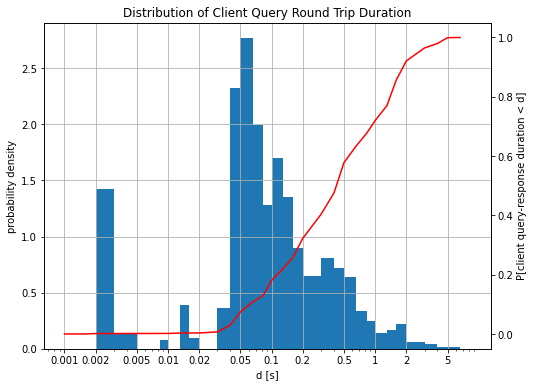

In [470]:
# client query duration distribution

queries['duration'] = queries['finished'] - queries['started']

data = queries['duration'].astype(np.float).dropna()
bins = [b*10**p for p in [-3, -2, -1, 0] for b in [1,1.3,1.6,2,3,4,5,6.6,8.3]]
labels = bins[::3]
hist, bin_edges = np.histogram(data, bins=bins)
cdf = np.cumsum(hist)

plt.figure(figsize=(8, 6))
plt.grid(True)

ax, tax = plt.gca(), plt.twinx()

ax.hist(data, bins=bins, density=True)
ax.set_ylabel('probability density')
ax.set_xlabel('d [s]')

tax.plot(bin_edges[:-1], cdf/cdf[-1], c='r')
tax.set_ylabel('P[client query-response duration < d]')

plt.xscale('log')
plt.xticks(labels, map(str, labels))
plt.title('Distribution of Client Query Round Trip Duration')

None

In [330]:
# show a single query to the server

for p in queries.iloc[200]['server_packets']:
    if p[DNS].qr != 0:
        continue
    print(p[IP].show())

###[ IP ]### 
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 138
  id        = 17010
  flags     = DF
  frag      = 0
  ttl       = 54
  proto     = udp
  chksum    = 0xf360
  src       = 217.31.204.137
  dst       = 130.149.230.81
  \options   \
###[ UDP ]### 
     sport     = 52224
     dport     = domain
     len       = 118
     chksum    = 0x7568
###[ DNS ]### 
        id        = 46538
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 0
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 1
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 1
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'oPn-nAMED-cznic-oDvr-20210624190031.rSASHA1nsec3sHa1-1871-3-SigNeDoK.5B.DNstb.net.'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
 